In [ ]:
# 1. Initialize Client and Load Data

import pandas as pd
import numpy as np
from agentds import BenchmarkClient

# 🔑 REPLACE WITH YOUR CREDENTIALS
client = BenchmarkClient(
    api_key="your-api-key-here",        # Get from your team dashboard
    team_name="your-team-name-here"     # Your exact team name
)

# Load data from PVC paths
print("📂 Loading Manufacturing Challenge 3 data...")

# Load shift workload data
train_shifts = pd.read_csv("../Manufacturing/shift_workload_train.csv")
test_shifts = pd.read_csv("../Manufacturing/shift_workload_test.csv")

print(f"✅ Data loaded:")
print(f"   Train shifts: {train_shifts.shape}")
print(f"   Test shifts: {test_shifts.shape}")
print(f"   Train columns: {list(train_shifts.columns)}")
print(f"   Test columns: {list(test_shifts.columns)}")

📂 Loading Manufacturing Challenge 3 data...
✅ Data loaded:
   Train shifts: (13575, 8)
   Test shifts: (13575, 7)
   Train columns: ['date', 'shift', 'machine_id', 'planned_jobs', 'avg_proc_time_min', 'std_proc_time_min', 'ambient_temp_c', 'HoursDelayed']
   Test columns: ['date', 'shift', 'machine_id', 'planned_jobs', 'avg_proc_time_min', 'std_proc_time_min', 'ambient_temp_c']


In [3]:
prod_logs = pd.read_json("../Manufacturing/production_logs.json")
op_logs = pd.read_json("../Manufacturing/operator_logs.json")

In [4]:
prod_logs["date"] = pd.to_datetime(prod_logs["date"]).dt.date
op_logs["date"] = pd.to_datetime(op_logs["date"]).dt.date

train_shifts["date"] = pd.to_datetime(train_shifts["date"]).dt.date
test_shifts["date"] = pd.to_datetime(test_shifts["date"]).dt.date

In [5]:
prod_logs['delay_flag'] = prod_logs["log_text"].str.contains("delayed", case=False).astype(int)
prod_logs['failure_flag'] = prod_logs["log_text"].str.contains(r"\b(failure|stoppage|freeze|emergency|intervention)\b", case=False).astype(int)

op_logs['op_normal_flag'] = op_logs["log_text"].str.contains(r"\b(normally|smoothly|operating)\b", case=False).astype(int)

/var/folders/wh/mfvt_xdj2p14fhld48z58q0r0000gn/T/ipykernel_33270/106121764.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  prod_logs['failure_flag'] = prod_logs["log_text"].str.contains(r"\b(failure|stoppage|freeze|emergency|intervention)\b", case=False).astype(int)
/var/folders/wh/mfvt_xdj2p14fhld48z58q0r0000gn/T/ipykernel_33270/106121764.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  op_logs['op_normal_flag'] = op_logs["log_text"].str.contains(r"\b(normally|smoothly|operating)\b", case=False).astype(int)


In [6]:
prod_logs2 = prod_logs[['machine_id', 'date', 'shift', 'delay_flag', 'failure_flag']]
op_logs2 = op_logs[['machine_id', 'date', 'shift', 'op_normal_flag']]

In [7]:
train = train_shifts.merge(prod_logs, on=["machine_id", "date", "shift"], how="left")
train = train.merge(op_logs, on=["machine_id", "date", "shift"], how="left")

test = test_shifts.merge(prod_logs, on=["machine_id", "date", "shift"], how="left")
test = test.merge(op_logs, on=["machine_id", "date", "shift"], how="left")

In [8]:
train['total_job_time'] = train['planned_jobs'] * (train['avg_proc_time_min'])

test['total_job_time'] = test['planned_jobs'] * (test['avg_proc_time_min'])

In [9]:
target = "HoursDelayed"
features = [c for c in train.columns if c not in ["machine_id", "date", "shift", target]]

In [10]:
print(features)

['planned_jobs', 'avg_proc_time_min', 'std_proc_time_min', 'ambient_temp_c', 'operator_id_x', 'operator_name_x', 'log_text_x', 'delay_flag', 'failure_flag', 'operator_id_y', 'operator_name_y', 'log_text_y', 'op_normal_flag', 'total_job_time']


In [11]:
X_train = train[features]
y_train = train[target]
X_test = test[features]

In [12]:
from sklearn.model_selection import GroupKFold
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [13]:
mse_scores = []

Here were out best params in the middle of the challenge using parameter selection: {'num_leaves': 31, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'lambda_l1': 0, 'lambda_l2': 0, 'min_data_in_leaf': 100, 'max_depth': 8, 'objective': 'rmse', 'learning_rate': 0.03, 'verbose': -1, 'seed': 42, 'n_estimators': 3000} => MSE: 1.080210

We realized the feature, total_job_time, was hurting us more than helping us, so we re ran the model selection step without it.

Fold 1 MSE: 0.957804
Fold 2 MSE: 0.993498
Fold 3 MSE: 0.952798
Fold 4 MSE: 1.034426
Fold 5 MSE: 1.006219
Mean CV MSE: 0.988949


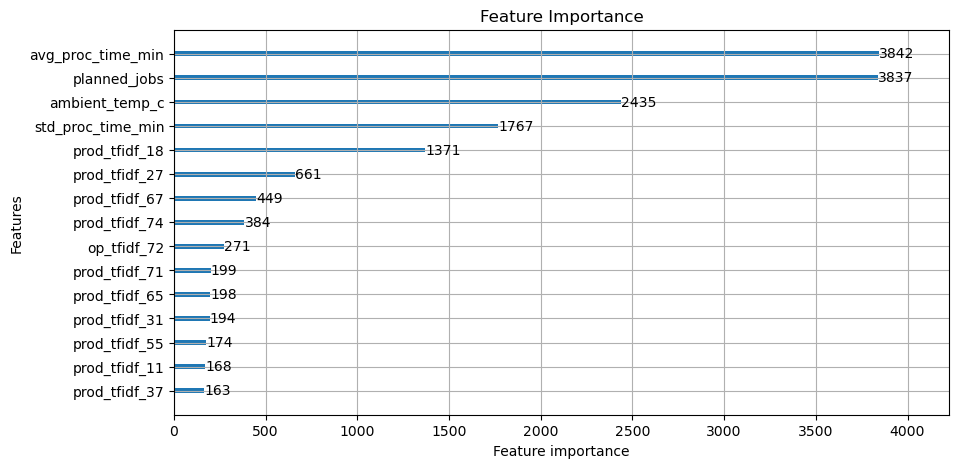

✅ Submission saved!


In [18]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import matplotlib.pyplot as plt

# ---------- Paths ----------
TRAIN_SHIFTS_PATH = "../Manufacturing/shift_workload_train.csv"
TEST_SHIFTS_PATH  = "../Manufacturing/shift_workload_test.csv"
PROD_LOGS_PATH    = "../Manufacturing/production_logs.json"
OP_LOGS_PATH      = "../Manufacturing/operator_logs.json"

# ---------- Load Data ----------
train = pd.read_csv(TRAIN_SHIFTS_PATH)
test  = pd.read_csv(TEST_SHIFTS_PATH)
prod_logs = pd.read_json(PROD_LOGS_PATH)
op_logs   = pd.read_json(OP_LOGS_PATH)

# Normalize date columns
for df in [train, test, prod_logs, op_logs]:
    df["date"] = pd.to_datetime(df["date"]).dt.date

# ---------- TF-IDF Embeddings ----------
MAX_FEATURES = 81  # can adjust

# Production logs TF-IDF
prod_vectorizer = TfidfVectorizer(max_features=MAX_FEATURES, stop_words='english')
prod_tfidf = prod_vectorizer.fit_transform(prod_logs["log_text"])
prod_emb_df = pd.DataFrame(prod_tfidf.toarray(), columns=[f"prod_tfidf_{i}" for i in range(MAX_FEATURES)])
prod_emb_df[["machine_id","date","shift"]] = prod_logs[["machine_id","date","shift"]]

# Operator logs TF-IDF
op_vectorizer = TfidfVectorizer(max_features=MAX_FEATURES, stop_words='english')
op_tfidf = op_vectorizer.fit_transform(op_logs["log_text"])
op_emb_df = pd.DataFrame(op_tfidf.toarray(), columns=[f"op_tfidf_{i}" for i in range(MAX_FEATURES)])
op_emb_df[["machine_id","date","shift"]] = op_logs[["machine_id","date","shift"]]

# ---------- Merge embeddings into main train/test ----------
train = train.merge(prod_emb_df, on=["machine_id","date","shift"], how="left")
train = train.merge(op_emb_df, on=["machine_id","date","shift"], how="left")
test = test.merge(prod_emb_df, on=["machine_id","date","shift"], how="left")
test = test.merge(op_emb_df, on=["machine_id","date","shift"], how="left")

train = train.merge(prod_logs2, on=["machine_id", "date", "shift"], how="left")
test = test.merge(prod_logs2, on=["machine_id", "date", "shift"], how="left")
train = train.merge(op_logs2, on=["machine_id", "date", "shift"], how="left")
test = test.merge(op_logs2, on=["machine_id", "date", "shift"], how="left")

# Fill NaNs for missing logs
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

# ---------- Other features ----------
# train['total_job_time'] = train['planned_jobs'] * train['avg_proc_time_min']
# test['total_job_time']  = test['planned_jobs'] * test['avg_proc_time_min']

# ---------- Prepare LightGBM ----------
TARGET = "HoursDelayed"
drop_cols = ["machine_id", "date", "shift", TARGET]
features = [c for c in train.columns if c not in drop_cols]

X_train = train[features].copy()
y_train = train[TARGET].copy()
X_test  = test[features].copy()

# Categorical columns (if any remain)
for col in ["shift"]:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype("category")
        X_test[col]  = X_test[col].astype("category")

# ---------- GroupKFold CV ----------
groups = train["machine_id"].values
gkf = GroupKFold(n_splits=5)

lgb_params = {
    "objective": "rmse",
    "metric": "mse",
    "boosting_type": "gbdt",
    "num_leaves": 20,
    "max_depth": 3,
    "learning_rate": 0.003, #best 0.003
    "feature_fraction": 1.0,
    "bagging_fraction": 0.9,
    "bagging_freq": 1,
    "lambda_l2": 0.0,
    "n_estimators": 3000,
    "random_state": 42,
    "verbose": -1
}


mse_scores = []
for fold, (tr_idx, val_idx) in enumerate(gkf.split(X_train, y_train, groups), 1):
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

    model = lgb.LGBMRegressor(**lgb_params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric="mse",
    )

    preds = model.predict(X_val)
    mse = mean_squared_error(y_val, preds)
    mse_scores.append(mse)
    print(f"Fold {fold} MSE: {mse:.6f}")

print(f"Mean CV MSE: {np.mean(mse_scores):.6f}")

# ---------- Train final model ----------
final_model = lgb.LGBMRegressor(**lgb_params)
final_model.fit(X_train, y_train)

# ---------- Feature Importance ----------
lgb.plot_importance(final_model, figsize=(10,5), max_num_features=15)
plt.title("Feature Importance")
plt.show()

# ---------- Predict ----------
predictions = final_model.predict(X_test)

# ---------- Save submission ----------
submission = pd.DataFrame({
    "machine_id": test["machine_id"],
    "date": pd.to_datetime(test["date"]).dt.strftime("%Y-%m-%d"),
    "shift": test["shift"],
    "HoursDelayed": predictions
})
submission.to_csv("manufacturing_challenge3_predictions.csv", index=False)
print("✅ Submission saved!")

We ran the below parameter selection step to help choose parameters for LightGBM model.

In [19]:
from itertools import product
import random
from tqdm import tqdm
param_grid = {
  "num_leaves": [8, 15, 31],
  "min_data_in_leaf": [15, 30, 60],
  "feature_fraction": [0.8, 0.9, 1.0],
  "bagging_fraction": [0.8, 0.9],
  "lambda_l2": [0.0, 0.1, 0.2],
  "n_estimators": [3000, 4000, 5000]
}

param_combos = list(product(*param_grid.values()))

best_score = float("inf")
best_params = None

param_combos = random.sample(param_combos, 30)

# --- Start tuning ---
for combo in tqdm(param_combos, desc="Tuning LGBM (MSE)"):
    params = dict(zip(param_grid.keys(), combo))
    params.update({
        "objective": "rmse",          # RMSE objective → minimizes MSE
        "verbose": -1,
        "seed": 42,
        "max_depth": 3,
        "boosting_type": "gbdt",
        "learning_rate": 0.003
    })

    fold_scores = []

    for tr_idx, val_idx in gkf.split(X_train, y_train, groups):  # Use original (non-log) target
        X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train[tr_idx], y_train[val_idx]

        model = lgb.LGBMRegressor(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric="rmse",
        )

        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        fold_scores.append(mse)

    mean_mse = np.mean(fold_scores)

    print(f"{params} => MSE: {mean_mse:.6f}")
    if mean_mse < best_score:
        best_score = mean_mse
        best_params = params

print("\n✅ Best params:", best_params)
print("✅ Best mean MSE:", best_score)

Tuning LGBM (MSE):   3%|▎         | 1/30 [00:14<06:57, 14.39s/it]

{'num_leaves': 15, 'min_data_in_leaf': 15, 'feature_fraction': 0.8, 'bagging_fraction': 0.9, 'lambda_l2': 0.2, 'n_estimators': 4000, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'max_depth': 3, 'boosting_type': 'gbdt', 'learning_rate': 0.003} => MSE: 0.989709


Tuning LGBM (MSE):   7%|▋         | 2/30 [00:24<05:33, 11.92s/it]

{'num_leaves': 31, 'min_data_in_leaf': 60, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'lambda_l2': 0.2, 'n_estimators': 3000, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'max_depth': 3, 'boosting_type': 'gbdt', 'learning_rate': 0.003} => MSE: 0.990468


Tuning LGBM (MSE):  10%|█         | 3/30 [00:42<06:35, 14.64s/it]

{'num_leaves': 31, 'min_data_in_leaf': 30, 'feature_fraction': 0.8, 'bagging_fraction': 0.9, 'lambda_l2': 0.0, 'n_estimators': 5000, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'max_depth': 3, 'boosting_type': 'gbdt', 'learning_rate': 0.003} => MSE: 0.991151


Tuning LGBM (MSE):  13%|█▎        | 4/30 [00:51<05:21, 12.37s/it]

{'num_leaves': 8, 'min_data_in_leaf': 15, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'lambda_l2': 0.2, 'n_estimators': 3000, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'max_depth': 3, 'boosting_type': 'gbdt', 'learning_rate': 0.003} => MSE: 0.989115


Tuning LGBM (MSE):  17%|█▋        | 5/30 [01:05<05:26, 13.07s/it]

{'num_leaves': 15, 'min_data_in_leaf': 15, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'lambda_l2': 0.2, 'n_estimators': 4000, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'max_depth': 3, 'boosting_type': 'gbdt', 'learning_rate': 0.003} => MSE: 0.990413


Tuning LGBM (MSE):  20%|██        | 6/30 [01:20<05:26, 13.59s/it]

{'num_leaves': 8, 'min_data_in_leaf': 30, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'lambda_l2': 0.0, 'n_estimators': 5000, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'max_depth': 3, 'boosting_type': 'gbdt', 'learning_rate': 0.003} => MSE: 0.991637


Tuning LGBM (MSE):  23%|██▎       | 7/30 [01:31<04:51, 12.67s/it]

{'num_leaves': 31, 'min_data_in_leaf': 15, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'lambda_l2': 0.1, 'n_estimators': 3000, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'max_depth': 3, 'boosting_type': 'gbdt', 'learning_rate': 0.003} => MSE: 0.989802


Tuning LGBM (MSE):  27%|██▋       | 8/30 [01:40<04:18, 11.76s/it]

{'num_leaves': 8, 'min_data_in_leaf': 15, 'feature_fraction': 1.0, 'bagging_fraction': 0.8, 'lambda_l2': 0.0, 'n_estimators': 3000, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'max_depth': 3, 'boosting_type': 'gbdt', 'learning_rate': 0.003} => MSE: 0.990135


Tuning LGBM (MSE):  30%|███       | 9/30 [01:52<04:06, 11.73s/it]

{'num_leaves': 15, 'min_data_in_leaf': 30, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'lambda_l2': 0.1, 'n_estimators': 3000, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'max_depth': 3, 'boosting_type': 'gbdt', 'learning_rate': 0.003} => MSE: 0.990430


Tuning LGBM (MSE):  33%|███▎      | 10/30 [02:06<04:05, 12.30s/it]

{'num_leaves': 15, 'min_data_in_leaf': 30, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'lambda_l2': 0.0, 'n_estimators': 4000, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'max_depth': 3, 'boosting_type': 'gbdt', 'learning_rate': 0.003} => MSE: 0.991030


Tuning LGBM (MSE):  37%|███▋      | 11/30 [02:21<04:13, 13.33s/it]

{'num_leaves': 15, 'min_data_in_leaf': 30, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'lambda_l2': 0.2, 'n_estimators': 5000, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'max_depth': 3, 'boosting_type': 'gbdt', 'learning_rate': 0.003} => MSE: 0.991691


Tuning LGBM (MSE):  40%|████      | 12/30 [02:37<04:11, 13.95s/it]

{'num_leaves': 8, 'min_data_in_leaf': 15, 'feature_fraction': 0.8, 'bagging_fraction': 0.9, 'lambda_l2': 0.2, 'n_estimators': 3000, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'max_depth': 3, 'boosting_type': 'gbdt', 'learning_rate': 0.003} => MSE: 0.989115


Tuning LGBM (MSE):  43%|████▎     | 13/30 [02:50<03:55, 13.87s/it]

{'num_leaves': 31, 'min_data_in_leaf': 60, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'lambda_l2': 0.2, 'n_estimators': 3000, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'max_depth': 3, 'boosting_type': 'gbdt', 'learning_rate': 0.003} => MSE: 0.989946


Tuning LGBM (MSE):  47%|████▋     | 14/30 [03:05<03:46, 14.14s/it]

{'num_leaves': 15, 'min_data_in_leaf': 15, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'lambda_l2': 0.2, 'n_estimators': 4000, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'max_depth': 3, 'boosting_type': 'gbdt', 'learning_rate': 0.003} => MSE: 0.989709


Tuning LGBM (MSE):  50%|█████     | 15/30 [03:17<03:24, 13.62s/it]

{'num_leaves': 8, 'min_data_in_leaf': 30, 'feature_fraction': 0.8, 'bagging_fraction': 0.9, 'lambda_l2': 0.1, 'n_estimators': 3000, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'max_depth': 3, 'boosting_type': 'gbdt', 'learning_rate': 0.003} => MSE: 0.989766


Tuning LGBM (MSE):  53%|█████▎    | 16/30 [03:33<03:20, 14.33s/it]

{'num_leaves': 31, 'min_data_in_leaf': 60, 'feature_fraction': 1.0, 'bagging_fraction': 0.9, 'lambda_l2': 0.0, 'n_estimators': 5000, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'max_depth': 3, 'boosting_type': 'gbdt', 'learning_rate': 0.003} => MSE: 0.992174


Tuning LGBM (MSE):  57%|█████▋    | 17/30 [03:59<03:48, 17.58s/it]

{'num_leaves': 31, 'min_data_in_leaf': 60, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'lambda_l2': 0.1, 'n_estimators': 5000, 'objective': 'rmse', 'verbose': -1, 'seed': 42, 'max_depth': 3, 'boosting_type': 'gbdt', 'learning_rate': 0.003} => MSE: 0.991781


Tuning LGBM (MSE):  57%|█████▋    | 17/30 [04:05<03:07, 14.42s/it]


KeyboardInterrupt: 

In [125]:
# final_model = lgb.LGBMRegressor(
#     n_estimators=3000,
#     learning_rate=0.0021,#was 0.0021
#     num_leaves=12, #was 8
#     max_depth=3,
#     min_data_in_leaf=5,
#     feature_fraction=0.8,
#     # bagging_fraction=0.9,
#     # bagging_freq=1,
#     lambda_l2=0.3,#was 0.1
#     verbose=-1,
#     random_state=42,
#     boosting_type="goss"
# )
final_model = lgb.LGBMRegressor( #WINNER
    n_estimators=3200,           # Between 3000-3600
    learning_rate=0.0021,
    num_leaves=12,               # Your proven best (12 not 13)
    max_depth=3,
    min_data_in_leaf=4,          # Between 3-5
    min_gain_to_split=0.001,     # Lower than 0.002 for more splits
    feature_fraction=0.8,
    lambda_l1=0.1,               # Lighter L1 than 0.2
    lambda_l2=0.3,
    verbose=-1,
    random_state=42,
    boosting_type="goss"
)




lgb_params = {
    "objective": "rmse",
    "metric": "mse",
    "boosting_type": "gbdt",
    "num_leaves": 8,
    "max_depth": 3,
    "learning_rate": 0.003, #best 0.003
    "feature_fraction": 0.8,
    "bagging_fraction": 0.9,
    "bagging_freq": 1,
    "lambda_l2": 0.2,
    "n_estimators": 3000,
    "random_state": 42,
    "verbose": -1
}


final_model.fit(X_train, y_train, eval_metric="rmse")

LGBMRegressor(boosting_type='goss', feature_fraction=0.8, lambda_l1=0.1,
              lambda_l2=0.3, learning_rate=0.0021, max_depth=3,
              min_data_in_leaf=4, min_gain_to_split=0.001, n_estimators=3200,
              num_leaves=12, random_state=42, verbose=-1)

In [126]:
predictions = final_model.predict(X_test)

In [127]:
submission_df = pd.DataFrame({
    'date': test_shifts['date'],
    'shift': test_shifts['shift'],
    'machine_id': test_shifts['machine_id'],
    'HoursDelayed': predictions
})

# Save predictions
submission_df.to_csv("manufacturing_challenge3_predictions.csv", index=False)
print(f"✅ Predictions saved: {submission_df.shape[0]} predictions")
print(f"   Preview: {submission_df.head(3)}")
print(f"   Delay range: {predictions.min():.2f} to {predictions.max():.2f} hours")

✅ Predictions saved: 13575 predictions
   Preview:          date  shift machine_id  HoursDelayed
0  2025-01-01      1    MCH_002      2.659677
1  2025-01-01      1    MCH_004      2.056205
2  2025-01-01      1    MCH_007      2.186284
   Delay range: 1.27 to 11.55 hours


In [128]:
# 3. Submit Predictions

# Submit predictions to the competition
print("🚀 Submitting predictions...")

try:
    result = client.submit_prediction("Manufacturing", 3, "manufacturing_challenge3_predictions.csv")
    
    if result['success']:
        print("✅ Submission successful!")
        print(f"   📊 Score: {result['score']:.4f}")
        print(f"   📏 Metric: {result['metric_name']}")
        print(f"   ✔️  Validation: {'Passed' if result['validation_passed'] else 'Failed'}")
    else:
        print("❌ Submission failed!")
        print(f"   Error details: {result.get('details', {}).get('validation_errors', 'Unknown error')}")
        
except Exception as e:
    print(f"💥 Submission error: {e}")
    print("🔧 Check your API key and team name are correct!")

print("\n🎯 Next steps:")
print("   1. Try incorporating relevant information outside this table!")
print("   2. You've completed all Manufacturing challenges!")


🚀 Submitting predictions...
✅ Prediction submitted successfully!
📊 Score: 0.9923 (MSE)
✅ Validation passed
✅ Submission successful!
   📊 Score: 0.9923
   📏 Metric: MSE
   ✔️  Validation: Passed

🎯 Next steps:
   1. Try incorporating relevant information outside this table!
   2. You've completed all Manufacturing challenges!
